# Human Activity Recognition
This notebook provides some guidelines for building a classifier for the MotionSense dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Generate time-series data
The original MotionSense dataset comes in a slightly cumbersome format, but the authors do provide a few functions to produce Pandas DataFrames with control over what is produced. For our purposes we are not concerned with all of the target data, as we only need to know the activity that was being recorded. 

In [3]:
def get_ds_infos():
    """
    Read the file includes data subject information.

    EEE4114: Technically we do not need these data, as we are not concerned about identifying the subjects. 
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains information about data subjects' attributes 
    """ 

    dss = pd.read_csv("../data/data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset. 

    EEE4114F: Choose sensors that you think are useful or would like to include in training. 
    You can choose all of them, or you could opt to try a limited set of input features
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    EEE4114F: This defines what data you would like to include for a given set.  

    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimension of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeled dataset. False, if we only want sensor values.

    Returns:
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = '../data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

You would need to decide what to include in your dataset, for example if you want to try a reduce dataset with only a few sensors then you can alter the `sdt` list. 

In [4]:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS #[0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


In [5]:
dataset

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0
...,...,...,...,...,...,...,...
1412860,-2.368280,-0.381075,-0.089417,0.000789,-0.005937,-0.004355,5.0
1412861,-2.368752,-0.381071,-0.089478,-0.000409,-0.000608,0.000098,5.0
1412862,-2.369130,-0.381163,-0.089465,-0.000486,0.000711,0.002045,5.0
1412863,-2.369372,-0.381295,-0.089468,0.000311,-0.003395,0.004746,5.0


# Data Pre-processing
There are numerous approaches to solving this task and your choice of algorithm will determine what form your input data should take. For example, a feed-forward neural network could be used, but what type of representation would make sense? Without being able to account for the temporal structure of the data, feed-forward networks might fail. One way around this is to potentially use summarized statistics about the data to simplify the features in a way that is not reliant on temporal information. E.g. instead of the raw signal for the acceleration, what if you worked with the mean? This might not be the best approach, compared to other algorithms, but it could be useful for a feed-forward network.

what about convolutional neural networks? Well, you could use 1D convolutions directly on time-series data which would then result in fewer model parameters compared to a fully-connected network, with the added benefit of retaining temporal information. Alternatively you could look to transform the time-series data into 2D data using something such as an FFT to produce a spectogram. Or for something simpler you can create fixed windows to divide your dataset into chunks of 2D data e.g. for 6 sensors and a window of 400 samples you would generate a 6 x 400 input. 

In [6]:
def windows(dataset, window_size=400, stride=200):
    """
    Create fixed-length windows of the input data. 

    Args:
        dataset: DataFrame of the time-series data
        size: (int) the size of the windows in number of samples.
        stride: (int) the stride length of the windows. 

    Returns:
        windows_df: DataFrame of the windowed time-series data. Each window should have the shape (n_sensors, window_size). 
            The number of examples will change depending on the stride.    

    """

    features = dataset.iloc[:, :-1].values  # Shape: (N, 6)
    labels = dataset.iloc[:, -1].values     # Shape: (N,)
    
    windows_list = []
    
    for start in range(0, len(dataset) - window_size + 1, stride):
        end = start + window_size
        window = features[start:end].T  # Transpose to shape (6, window_size)
        window_labels = labels[start:end]
        label = Counter(window_labels).most_common(1)[0][0]  # Mode label
        windows_list.append((window, label))

    return windows_list

In [7]:
def windows_no_event_overlap(dataset, window_size=400, stride=200):
    features = dataset.iloc[:, :-1].values  # All sensor columns (shape: N x 6)
    labels = dataset.iloc[:, -1].values     # Activity labels (shape: N,)

    windows_list = []
    start = 0
    N = len(dataset)

    while start + window_size <= N:
        end = start + window_size
        current_labels = labels[start:end]

        # If all labels in the window are the same, accept the window
        if np.all(current_labels == current_labels[0]):
            window = features[start:end].T  # Shape: (6, window_size)
            label = current_labels[0]       # Label is just that class
            windows_list.append((window, label))
            start += stride
        else:
            # Skip ahead until we find a new contiguous segment of the same activity
            next_change = np.where(labels[start:] != labels[start])[0]
            if len(next_change) == 0:
                break  # No more activity changes
            start += next_change[0]  # Move to the start of the next activity block

    return windows_list

In [8]:
blah = windows(dataset)
print(len(blah))
np.shape(blah[7062][0])

7063


(6, 400)

In [9]:
x = [x[0] for x in blah]
y = [x[1] for x in blah]

np.shape(x)

(7063, 6, 400)

# Pytorch Dataset
If using Pytorch it is useful to create datasets using their dataset structures. This may require modification if using additional transformations, or formats

In [10]:
class MotionSense(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X.values)
        self.Y = torch.tensor(Y.values)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

In [11]:
class MotionSense2(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.X[index]
        y = self.Y[index]

        return x, y

    def __len__(self):
        return len(self.X)

# Resampling
You can split the dataset using sklearn, but you need to take care with your specific data. For example, randomly splitting raw sensor data will result in jumbled time-series signals. 

In [12]:
X = dataset[dt_list[0]+dt_list[1]] # You could collect the input and target data as separate dataframes
Y = dataset.act

In [13]:
# You may be tempted to use train_test_split directly. But if using raw sensor data this would randomize the signals and not retain the order. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False) 

In [14]:
X_train.head() 

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299


In [15]:
# Split the data - Holdout

train_set, test_set = train_test_split(blah, test_size=0.2, shuffle=False)

In [16]:
x_train = [x[0] for x in train_set]
y_train = [x[1] for x in train_set]

x_test = [x[0] for x in test_set]
y_test = [x[1] for x in test_set]

Notice the indeces are all jumbled? If using windowed data the usual splitting methods work, as each window retains the order of sensor values, as long as you split the data along the correct axis. 

If using summarized data e.g. taking the mean, max, min etc. as input features rather than the raw data then you should be fine using train_test_split.

If working with raw sensor data there is an sklearn fuction for splitting time series data to make splitting raw signals easier if you want to work with that instead.

In [17]:
# Here is an example of the TimeSeriesSplit. It does create cross-validation data by default. 
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=10000,
    test_size=1000
)

all_splits = list(ts_cv.split(X ,Y)) # These are indices, not the data itself.

In [18]:
len(all_splits)

5

Once you have the indices you can sample the data

In [19]:
X.iloc[all_splits[0][0]].head() # This is the training input data from the first split
#print(all_splits)

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z
1397845,-0.958415,-1.273400,2.505994,0.000617,0.003797,-0.008409
1397846,-0.960113,-1.272760,2.506021,0.002792,0.017977,-0.011121
1397847,-0.961836,-1.272516,2.506426,0.008888,-0.009524,-0.004444
1397848,-0.961993,-1.272238,2.508011,0.013588,-0.003491,-0.006772
1397849,-0.959931,-1.272258,2.511630,0.022700,0.004926,-0.013137


In [20]:
Y.iloc[all_splits[0][0]].head() # This is the training target data from the first split. You can see the indices still match, and arre ordered correctly.

1397845    4.0
1397846    4.0
1397847    4.0
1397848    4.0
1397849    4.0
Name: act, dtype: float64

In [21]:
dataset.iloc[all_splits[0][0]]

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
1397845,-0.958415,-1.273400,2.505994,0.000617,0.003797,-0.008409,4.0
1397846,-0.960113,-1.272760,2.506021,0.002792,0.017977,-0.011121,4.0
1397847,-0.961836,-1.272516,2.506426,0.008888,-0.009524,-0.004444,4.0
1397848,-0.961993,-1.272238,2.508011,0.013588,-0.003491,-0.006772,4.0
1397849,-0.959931,-1.272258,2.511630,0.022700,0.004926,-0.013137,4.0
...,...,...,...,...,...,...,...
1407840,-2.668217,-0.082074,-0.419199,0.000806,-0.004513,-0.008178,5.0
1407841,-2.667989,-0.081651,-0.419106,-0.003584,-0.007875,-0.006763,5.0
1407842,-2.667739,-0.081444,-0.419184,0.001421,-0.003138,-0.004528,5.0
1407843,-2.667436,-0.081439,-0.419363,0.005139,-0.001729,0.001607,5.0


Once you have your splits, you can convert them to Pytorch datasets for easier loading. Technically you could offload the sampling methods to Pytorch samplers, but this can be trickier to implement.

In [22]:
train_1 = MotionSense(X.iloc[all_splits[0][0]].reset_index(drop=True), 
                      Y.iloc[all_splits[0][0]].reset_index(drop=True)) # reset_index is to make sure each new set is indexed from 0
train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

In [23]:
train_1 = MotionSense2(x_train, 
                      y_train) # reset_index is to make sure each new set is indexed from 0
train_1_loader = DataLoader(train_1, batch_size=5)  # Will load data in batches. Batching raw signals can be problematic if it cuts-off a given signal, or stitches it together with other signals etc.

/tmp/ipykernel_277167/3222263456.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.X = torch.tensor(X)


In [24]:
train_1_loader

In [25]:
#for X, Y in train_1_loader:
#    print(f"X={X}, Y={Y}")
dataset.iloc[all_splits[0][0]].shape

(10000, 7)

# Models
As mentioned previously there are a few options for the types of models you end up using.

# CNN Model=====================================

# DATA preparation for FCNet

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert lists to NumPy arrays if not already
X_train_cnn = np.array(x_train)  # shape: (N, 6, 400)
X_test_cnn = np.array(x_test)
y_train_cnn = np.array(y_train)
y_test_cnn = np.array(y_test)

# Create Tensors and reshape to (batch_size, 1, 6, 400)
X_train_cnn_tensor = torch.FloatTensor(X_train_cnn).unsqueeze(1)  # add channel dim: (N, 1, 6, 400)
X_test_cnn_tensor = torch.FloatTensor(X_test_cnn).unsqueeze(1)
y_train_cnn_tensor = torch.LongTensor(y_train_cnn)
y_test_cnn_tensor = torch.LongTensor(y_test_cnn)

# Dataset and DataLoader
train_cnn_dataset = TensorDataset(X_train_cnn_tensor, y_train_cnn_tensor)
test_cnn_dataset = TensorDataset(X_test_cnn_tensor, y_test_cnn_tensor)

batch_size = 64
train_cnn_loader = DataLoader(train_cnn_dataset, batch_size=batch_size, shuffle=True)
test_cnn_loader = DataLoader(test_cnn_dataset, batch_size=batch_size)


# Model Design

In [27]:
class FCNet (nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 20), stride=(1, 2), padding=(1, 10))
        self.pool = nn.MaxPool2d(kernel_size=(1, 2))  # pool only across time
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 10), stride=(1, 2), padding=(1, 5))
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 8)  # assuming 8 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, H, W)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, H, W)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
model = FCNet()
print(model)

FCNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 20), stride=(1, 2), padding=(1, 10))
  (pool): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 10), stride=(1, 2), padding=(1, 5))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=8, bias=True)
)


# Training
With your model defined you will need to decide on an optimizer used to perform parameter updates. The choice is yours, but for the most part default optimizers like Adam should work for CNNs, although SGD can be more stable but take longer to train. 

You can then load in data, for example if using the loader described before the loop shown below will iterate through batches of data. 

In [29]:
# Optimisations

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Initialize trackers
train_loss_history = []
train_acc_history = []
val_loss_history = []  # For validation if you have it
val_acc_history = []

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, Y in train_1_loader:
        X = X.view(X.size(0), 1, 6, 400).float().to(device)
        Y = Y.long().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    # Store epoch metrics
    epoch_loss = running_loss / len(train_1_loader)
    epoch_acc = 100 * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")



Epoch 1/20, Loss: 1.7050, Accuracy: 42.39%
Epoch 2/20, Loss: 1.1153, Accuracy: 53.88%
Epoch 3/20, Loss: 0.6874, Accuracy: 73.79%
Epoch 4/20, Loss: 0.4651, Accuracy: 81.95%
Epoch 5/20, Loss: 0.3161, Accuracy: 87.70%
Epoch 6/20, Loss: 0.2849, Accuracy: 89.70%
Epoch 7/20, Loss: 0.2248, Accuracy: 92.14%
Epoch 8/20, Loss: 0.3149, Accuracy: 91.19%
Epoch 9/20, Loss: 0.2876, Accuracy: 91.17%
Epoch 10/20, Loss: 0.1901, Accuracy: 93.88%
Epoch 11/20, Loss: 0.1462, Accuracy: 95.13%
Epoch 12/20, Loss: 0.1220, Accuracy: 95.73%
Epoch 13/20, Loss: 0.1037, Accuracy: 96.30%
Epoch 14/20, Loss: 0.1675, Accuracy: 95.50%
Epoch 15/20, Loss: 0.0747, Accuracy: 97.47%
Epoch 16/20, Loss: 0.0779, Accuracy: 97.52%
Epoch 17/20, Loss: 0.0993, Accuracy: 96.74%
Epoch 18/20, Loss: 0.0370, Accuracy: 98.69%
Epoch 19/20, Loss: 0.0339, Accuracy: 98.97%
Epoch 20/20, Loss: 0.0709, Accuracy: 98.23%


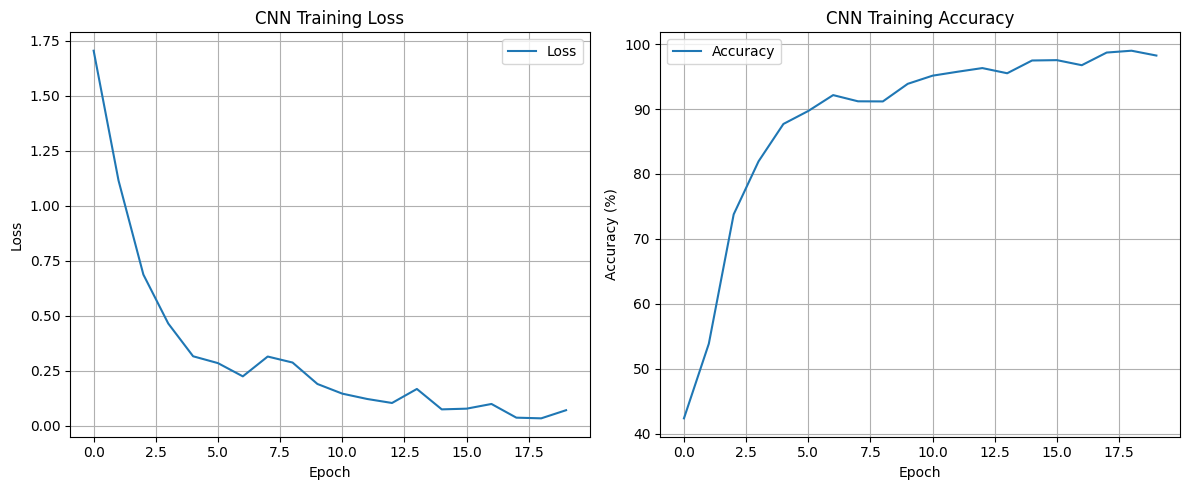

<Figure size 640x480 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt


#========================================= CNN training Loss and Accuracy===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Loss')
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Accuracy')
plt.title('CNN Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("CNN_Train_and_Accracy.png", dpi=300)






# Validation

# Evaluation
Make sure to correctly evaluate your models. Justify your methods given your particular model and data used e.g. if you use random holdout, is it justified? What do your performance metrics tell you e.g. was the model overfitting, underfitting, are their early stages in the training process where the model performs well compared to the end of training, which model do you choose to save, are the model outputs "reasonable" i.e. are there errors that might make sense given the data? 

# Confusion matrics plot

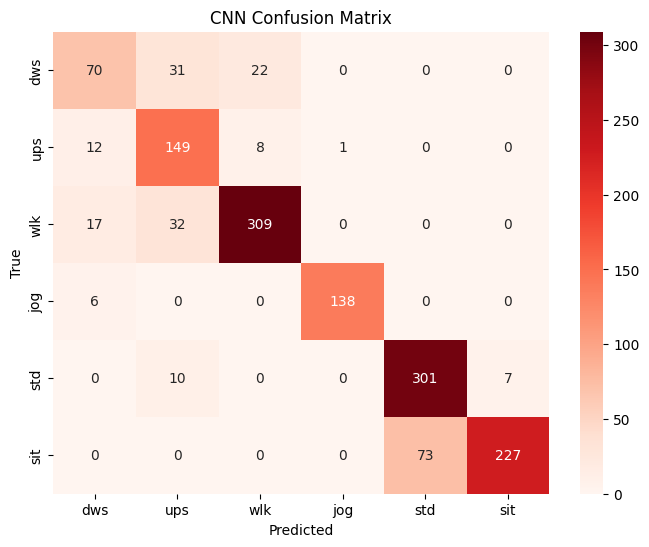

In [33]:
def plot_cm(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CNN Confusion Matrix')
    plt.show()

model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_x, batch_y in test_cnn_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

plot_cm(all_true, all_preds, ACT_LABELS)

# RANDOM FOREST TESTING =========================================

In [34]:
import numpy as np
from scipy import stats

def extract_features(window):
    """Extract features from a single window (shape: 6 x 400)."""
    features = []
    for sensor_data in window:  # Loop over each of the 6 sensors
        features.extend([
            np.mean(sensor_data),       # Avg value
            np.std(sensor_data),        # Standard deviation
            np.min(sensor_data),        # Min value
            np.max(sensor_data),        # Max value
            np.median(sensor_data),     # Median
            stats.skew(sensor_data),    # Skewness
            stats.kurtosis(sensor_data) # Kurtosis
        ])
    return features  # Returns 6 sensors × 7 features = 42 features per window

# Apply feature extraction to all windows
X_features = np.array([extract_features(window) for window in x])
y_labels = np.array(y)  # Shape: (7063,)

In [35]:
X_train = np.array([extract_features(window) for window in x_train])
X_test = np.array([extract_features(window) for window in x_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

Test Accuracy: 0.9617834394904459


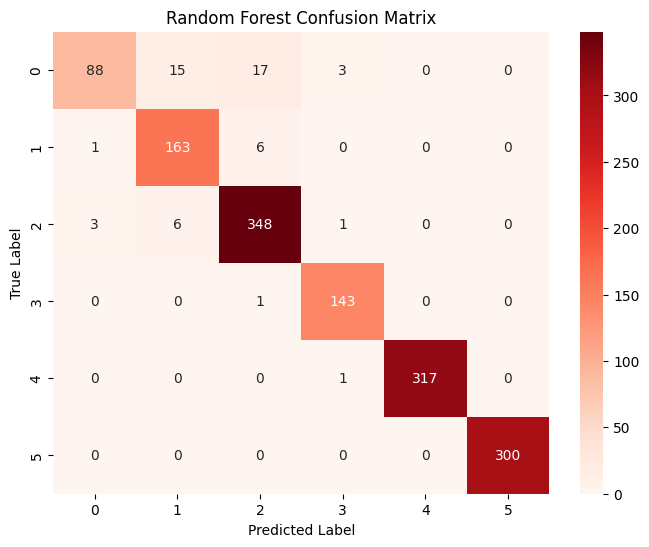

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train
rf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,   # For reproducibility
    n_jobs=-1         # Use all CPU cores
)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)


#this is for the report ===========================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

#==================================================================================


# Confusion Matrix

In [37]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_
feature_names = [f"Sensor_{i//7}_Stat_{i%7}" for i in range(X_train.shape[1])]

# Plot top N features
'''plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[:20], align='center')
plt.yticks(range(20), feature_names[:20])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features")
plt.show()'''

'plt.figure(figsize=(10, 6))\nplt.barh(range(20), importances[:20], align=\'center\')\nplt.yticks(range(20), feature_names[:20])\nplt.xlabel("Feature Importance")\nplt.title("Top 20 Important Features")\nplt.show()'

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


# 1. Data Preparation for LSTM

LSTMs expect input shape (samples, timesteps, features). We'll reshape your windowed data accordingly:

In [39]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert your existing windows to LSTM-friendly format
# x_train shape: [num_samples, 6, 400] -> [num_samples, 400, 6] (LSTM expects seq_len first)
X_train_lstm = np.array([window.T for window in x_train])  # Transpose to (samples, 400, 6)
X_test_lstm = np.array([window.T for window in x_test])    # Same for test set

# Convert labels to tensors
y_train_lstm = torch.LongTensor(y_train)
y_test_lstm = torch.LongTensor(y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.FloatTensor(X_train_lstm), y_train_lstm)
test_dataset = TensorDataset(torch.FloatTensor(X_test_lstm), y_test_lstm)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

2. LSTM Model Architecture

We'll use a bidirectional LSTM to capture both past and future context:

In [40]:
class HAR_LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, num_layers=2, num_classes=6):
        super(HAR_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch, seq_len, hidden_dim*2]
        
        # Use only the last timestep's output
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        return self.fc(last_output)

3. Training the LSTM

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HAR_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
lstm_train_acc = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()
    
    train_acc = 100 * correct / len(train_dataset)
    lstm_train_acc.append(train_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/20, Loss: 119.7575, Accuracy: 47.91%
Epoch 2/20, Loss: 99.9708, Accuracy: 57.43%
Epoch 3/20, Loss: 78.8609, Accuracy: 67.20%
Epoch 4/20, Loss: 75.0926, Accuracy: 68.67%
Epoch 5/20, Loss: 63.5724, Accuracy: 74.16%
Epoch 6/20, Loss: 63.0145, Accuracy: 73.38%
Epoch 7/20, Loss: 47.0967, Accuracy: 80.16%
Epoch 8/20, Loss: 61.4075, Accuracy: 74.60%
Epoch 9/20, Loss: 44.2988, Accuracy: 82.14%
Epoch 10/20, Loss: 39.2727, Accuracy: 83.70%
Epoch 11/20, Loss: 42.9730, Accuracy: 83.29%
Epoch 12/20, Loss: 36.1475, Accuracy: 85.47%
Epoch 13/20, Loss: 30.8702, Accuracy: 87.49%
Epoch 14/20, Loss: 44.1254, Accuracy: 84.39%
Epoch 15/20, Loss: 100.4306, Accuracy: 59.01%
Epoch 16/20, Loss: 90.4456, Accuracy: 64.19%
Epoch 17/20, Loss: 72.7609, Accuracy: 72.57%
Epoch 18/20, Loss: 55.8037, Accuracy: 77.81%
Epoch 19/20, Loss: 48.4711, Accuracy: 80.71%
Epoch 20/20, Loss: 43.2932, Accuracy: 82.39%


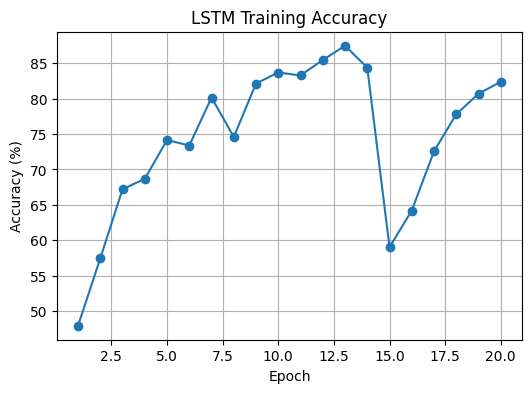

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), lstm_train_acc, marker='o')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.show()


# Confusion matrix for LSTM

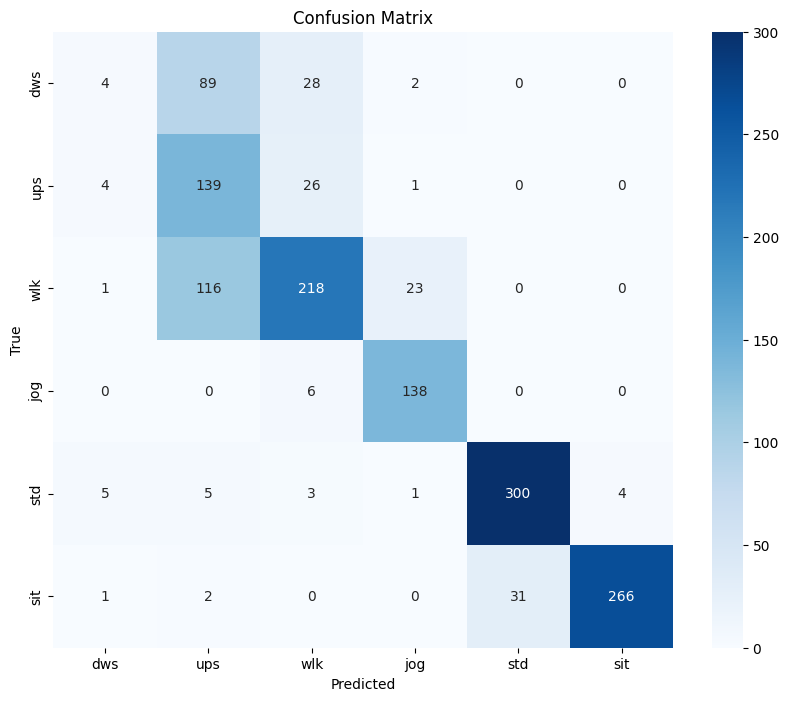

In [44]:



model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

plot_confusion_matrix(all_true, all_preds, classes=ACT_LABELS)

4. Evaluation

In [45]:
model.eval()
correct = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == batch_y).sum().item()

test_acc = 100 * correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 75.37%
